In [50]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats

%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

In [51]:
# Read in the dataset and take a look at the top few rows here:
df = pd.read_csv("ab_data.csv")

In [52]:
# find the number of rows in the dataset.
df.shape[0]

294478

In [53]:
#The number of unique users in the dataset.
df.user_id.nunique()

290584

In [54]:
#proportion of users converted.
df.converted.sum()/df.shape[0]

0.11965919355605512

In [55]:
#The number of times the new_page and treatment don't match.
do_not_match = df.query('(group == "treatment" and landing_page != "new_page") or (group != "treatment" and landing_page == "new_page")').shape[0]
do_not_match 

3893

In [56]:
# any of the rows have missing values?
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


### Any rows with missing values?
As evident from the above information there are no missing values in the data

In [57]:
#For the rows where treatment does not match with new_page or control 
#does not match with old_page, we cannot be sure if this row truly 
#received the new or old page.
df2 = df.query('(group == "treatment" and landing_page == "new_page") or (group == "control" and landing_page == "old_page")')\

df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [58]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

In [59]:
print('Number of unique user ids in df2', df2.user_id.nunique())

Number of unique user ids in df2 290584


In [60]:
#Find if we have any duplicate user_ids
df2[df2.duplicated(['user_id'], keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


### Repated User ID
User_Id 773192 is the repeated user id

### Row Information for repeated user_id
Above cell shows the information for the repeated user id (user_id 773192)

In [61]:
#Remove row with index 1899
df2 = df2.drop([1899])

In [62]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [63]:
# probability of an individual converting regardless of the page they receive
df2.converted.mean()

0.11959708724499628

In [64]:
#for individuals in the control group, what is the probability they converted?
df2.query('group == "control"').converted.mean()

0.1203863045004612

In [65]:
#for individuals in the treatment group, what is the probability they converted
df2.query('group == "treatment"').converted.mean()

0.11880806551510564

In [66]:
#probability that an individual received the new page
df2.query('landing_page == "new_page"').shape[0]/df2.shape[0]

0.5000619442226688

<a id='ab_test'></a>
### Part II - A/B Test


#### Hypothesis 
 Null Hypothesis :   
      $H_{0}$  : $p_{old}$ ${>=}$ $p_{new}$     
      i.e., conversion rate to old page is greater or equal to the conversion rate to new page 
   
 Alternative Hypothesis :   
      $H_{1}$  : $p_{old}$ ${<}$ $p_{new}$     
      i.e., conversion rate to old page is less than conversion to new page


In [67]:
#conversion rate for  𝑝𝑛𝑒𝑤  under the null
p_new = df2['converted'].mean()
p_new

0.11959708724499628

In [68]:
#conversion rate for  𝑝𝑜𝑙𝑑  under the null
p_old = df2['converted'].mean()
p_old

0.11959708724499628

In [69]:
#the number of individuals in the treatment group - nnew
n_new = df2.query('group == "treatment"').shape[0]
n_new

145310

In [70]:
#the number of individuals in the control group - nold
n_old = df2.query('group == "control"').shape[0]
n_old

145274

In [71]:
# Simulate  𝑛𝑛𝑒𝑤  transactions with a conversion rate of  𝑝𝑛𝑒𝑤  
# under the null. Store these  𝑛𝑛𝑒𝑤  1's and 0's in new_page_converted.
new_page_converted = np.random.choice([1,0],n_new, p=(p_new,1-p_new))
new_page_converted

array([0, 0, 0, ..., 0, 0, 0])

In [72]:
#Simulate  𝑛𝑜𝑙𝑑  transactions with a conversion rate of  𝑝𝑜𝑙𝑑  
# under the null. Store these  𝑛𝑜𝑙𝑑  1's and 0's in old_page_converted.
old_page_converted = np.random.choice([1,0],n_old, p=(p_old,1-p_old))
old_page_converted

array([0, 0, 0, ..., 1, 0, 0])

In [73]:
#pnew - pold for simulated values
p_sim_diff = old_page_converted.mean() - new_page_converted.mean()
p_sim_diff

3.6758249189680625e-05

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [74]:
#Create 10,000  𝑝𝑛𝑒𝑤  -  𝑝𝑜𝑙𝑑  values using the same simulation
new_page_converted = np.random.binomial(n_new, p_new, 10000)/n_new
old_page_converted = np.random.binomial(n_old, p_old, 10000)/n_old
p_diffs = new_page_converted - old_page_converted

Text(0,0.5,'Frequency')

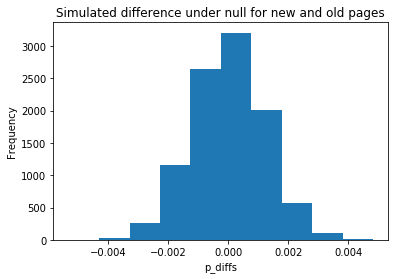

In [75]:
# histogram of the p_diffs
plt.hist(p_diffs)
plt.title('Simulated difference under null for new and old pages');
plt.xlabel('p_diffs')
plt.ylabel('Frequency')

In [76]:
# calculate proportion of the p_diffs are greater than the actual difference observed in ab_data.csv
old_mean = df2.query('group == "control"').converted.mean()
new_mean = df2.query('group == "treatment"').converted.mean()
obs_diff = new_mean - old_mean  
obs_diff

-0.0015782389853555567

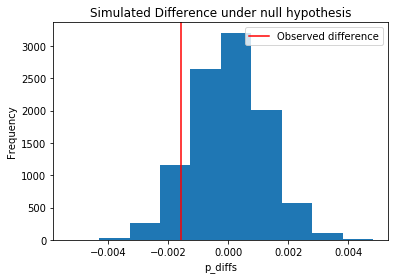

In [77]:
#plot for observed difference
plt.hist(p_diffs)
plt.axvline(x=obs_diff, color='red', label="Observed difference")
plt.xlabel('p_diffs')
plt.ylabel('Frequency')
plt.title('Simulated Difference under null hypothesis');
plt.legend()
plt.show()

In [78]:
#proportion of p_diffs greater than the observe difference
(p_diffs > obs_diff).mean()

0.90759999999999996

### observation 
90.76% is the proportion of the p_diffs are greater than the observed difference from the original data provided.

In [79]:
#n_old and n_new refer the the number of rows associated with the old page and new pages, respectively.
n_old = len(df2.query('landing_page =="old_page"'))
n_new = len(df2.query('landing_page =="new_page"'))
n_old, n_new

(145274, 145310)

In [80]:
convert_old = sum(df2.query('landing_page == "old_page"')['converted'])
convert_new = sum(df2.query('landing_page == "new_page"')['converted'])
convert_old, convert_new

(17489, 17264)

In [81]:
#compute test statistic and p-value 
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative='smaller')
z_score, p_value

(1.3109241984234394, 0.90505831275902449)

### z-score, p-value observation / conclusion:

The z-score and the p_value mean that we fail to reject the null hypothesis. In this case the null hypothesis, is the converted rate of the old page is the same or greater than the converted rate of the new page. 

A p_value of 90.51% is higher than the 5% statistically significance level. 
So, we fail to reject the null hypothesis thus implying we do not have sufficient evidence that new page (treatement) has more conversion rate than the old page (control). This implies we do not have enough confidence that the converted rate of the new page is higher than the old page.


<a id='regression'></a>
### Part III - A regression approach


As the response is categorical type (conversion or no conversion), Logistic Regression is best suited in this scenario

In [82]:
#map control group to 0 and treament group to 1
df2['intercept'] = 1
df2['ab_page'] = df2['group'].map({'treatment': 1, 'control': 0})
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


In [83]:
#Simulate regression model using the columns created above
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

lm = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = lm.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Thu, 29 Apr 2021   Pseudo R-squ.:               8.077e-06
Time:                        23:27:20   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

Summary is provided in the above output "Logit Regression Results section"

#### Observations
1) ab_page has a coeff value -0.0150 which indicates this has a weak correlation

2) p_value is 0.190 higher than 0.05 indicates we fail to reject the null hypothesis

3) p_value in this observation is significantly different from Part II, as in the logistic regression the dependent variable (ab_page) used is binary where as in the part II the dependent variable is continuous (thus linear while computing) and also in Part II we conducted a one-sided test (i.e., using alternative hypothesis,  pold < pnew) where as in the regression model we are calculating p-value using two-tail test.

#### Other factors to consider

1) Other factors that could impact is whether users participated in this observation on week-ends or week-days and the duration they spent before converting.

2) If more users participated on week-days they may not have gotten enough time to make an informed decision 

3) We could have conducted another hypthosis testing regarding the conversion rate among the users that spent time on week-ends vs week-days to see if this factor influences in conversion rate.

4) However, factoring in this might make the model more complex and invoving more computation conversion of the date column to week-day vs week-ends, time of the day etc.

In [84]:
#Read country data to calculate country effect
c_df = pd.read_csv('countries.csv')
c_df.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [85]:
# join this with ab_data
df3 = df2.merge(c_df, how='inner', on='user_id')
df3.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US


In [86]:
#look at an interaction between page and country
# by creating additional columns using dummy data
c_df['country'].unique()
df3[['UK', 'US']] = pd.get_dummies(df3['country'])[['UK','US']]
df3.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,UK,US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,1


In [87]:
#calculate summary data
df3['intercept'] = 1
log_mod = sm.Logit(df3['converted'], df3[['intercept', 'ab_page','UK', 'US']])
results = log_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Thu, 29 Apr 2021   Pseudo R-squ.:               2.323e-05
Time:                        23:27:33   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0300      0.027    -76.249      0.000      -2.082      -1.978
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
UK             0.0506      0.028      1.784      0.074      -0.005       0.106
US             0.0408      0.027      1.516      0.130      -0.012       0.093
==============================================================================
"""

In [88]:
np.exp(results.params)

intercept    0.131332
ab_page      0.985168
UK           1.051944
US           1.041599
dtype: float64

#### Observation
1) Based on the p-values for countries, (both being above 0.05), the location doesn't seem to play significant role in conversion rate

2) Converstion rates for Users in the countries that paricipated in this observation are about the same (i.e., conversion rate for UK users is about 1.05 times than Canada where as for US users it is 1.04 times than Canadian users)

In [89]:
#interaction between page and country to see if there significant effects on conversion
df3['ab_page_US'] = df3['ab_page'] * df3['US']
df3['ab_page_UK'] = df3['ab_page'] * df3['UK']

pg_cy_model = sm.Logit(df3['converted'], df3[['intercept','ab_page','US','UK','ab_page_US','ab_page_UK']])
results = pg_cy_model.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Thu, 29 Apr 2021   Pseudo R-squ.:               3.482e-05
Time:                        23:27:41   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0040      0.036    -55.008      0.000      -2.075      -1.933
ab_page       -0.0674      0.052     -1.297      0.195      -0.169       0.034
US             0.0175      0.038      0.465      0.642      -0.056       0.091
UK             0.0118      0.040      0.296      0.767      -0.066       0.090
ab_page_US     0.0469      0.054      0.872      0.383      -0.059       0.152
ab_page_UK     0.0783      0.057      1.378      0.168      -0.033       0.190
==============================================================================
"""

In [90]:
np.exp(results.params)

intercept     0.134794
ab_page       0.934776
US            1.017682
UK            1.011854
ab_page_US    1.048001
ab_page_UK    1.081428
dtype: float64

#### Observation
1) Based on the p-values above, the interaction between page-country interaction (i.e., whether users in one country served old where as others served new pages) didn't significant role in conversion rates.

2) In the same way, the conversion rate for this scenario is not any different than the previous observation when compared to Canadian users served with new pages versus when US or UK users served with new pages.

### References:

1) Labeling p-value histogram https://online.stat.psu.edu/stat555/node/61/

2) AttributeError: module 'scipy.stats' has no attribute 'chisqprob https://github.com/statsmodels/statsmodels/issues/3931

3) https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.merge.html#pandas.DataFrame.merge

4) Differences between one tailed and two tailed tests :
    https://stats.idre.ucla.edu/other/mult-pkg/faq/general/faq-what-are-the-differences-between-one-tailed-and-two-tailed-tests/

In [91]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0